# load in pheno types

In [3]:
from sklearn import decomposition
from tqdm import tqdm
import gc
from matplotlib import pyplot as plt
import seaborn as sns
import math
import scipy as sc
from random import randint, sample

from numba import jit

from scipy.spatial.distance import cosine
from scipy.stats import ks_2samp as ks2
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import kruskal
from scipy.stats import wasserstein_distance as w1_dist
from scipy.stats import energy_distance as w2_dist
from scipy.stats import anderson_ksamp as anderson # test if samples are from the same distribution
from scipy.interpolate import PchipInterpolator as minterp
from scipy.interpolate import CubicSpline as interp

from sklearn.linear_model import LogisticRegressionCV as LR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA

%reload_ext autoreload
%autoreload 2
#%load_ext autoreload

import numpy as np
import pandas as pd
import scipy as sc

from tqdm import tqdm

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectFdr
from sklearn.feature_selection import SelectFpr
from lifelines.statistics import logrank_test
from sklearn.metrics import r2_score

# Survival code
* different monotonic interpolators
    * Quadratic 
    * Cubic
    * Quartic
* different curve-generators
    * Kaplan-Meier curves    
    * Bayesian regressor
    * GAM/EBM
    * conditional log regression
    * Cox hazard regressor /proportional hazard model
* different hazard functions
    * empirical
    * Weibull
    * exponential
    * Gompertz
*  different curve comparison metrics
    * R2
    * Mann-Whitney U
    * euclidean distance
    * cosine similarity
    * integral probability metrics 
* plots
    * (years, cumulative survival probability)
    * (years, patient id sorted by time-to-event)
* bulk-survival comparator: 
    * create survival curve for 
    * extract monotonic cubic spline
    * extract pairwise distance metric
    * extract custom separation score

The main idea is to have a fast estimator to find features that seem to have a significant impact on the survival and to then use a more robust survival estimator for confirmation and a posteriori analysis. This is particularly useful to establish the impact of differential genetic expression.
    
# Test case

Combining the fact the Thyroid's production of T-cells is halved every 16 years, that 
the immune system is the first line of defense against beginning tumors, with the hypothesis that the effectivity
of immune system correlates directly with the T-cell count, leads to the hypothesis that the age is not a linear prediction factor for cancer incidence rates but rather an exponential predictor, more specifically: $$\rho_i \propto 2^\left(\frac{age}{16}\right)$$, and indeed according to [Palmer et al.](https://www.pnas.org/content/115/8/1883) this provided a better fit for the effect of age than a linear model. 

We will compare the linear model for age with the exponential model.

The caveat here is that we do not extract the actual T-cell count but rather the genomic "activity" for producing
T-cells, hence, we suffer from *omitted variable bias*. If we find *any* genewise over/underactivity, we should expect that the specific differential genes are related to hyper or hypothyroidism.

Genes of interest are (see [Panicker](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3219766/), 
[Medici et al.](https://www.sciencedirect.com/science/article/abs/pii/S1521690X17300301?via%3Dihub)):
* PDE8B
* DIO1, DIO2
* CAPZB
* TSHR, THRA, THRB
* MCT8, MCT10
* NTCP
* SLC10A1, SLC10A2, SLC16A10
* LAT1, LAT2
* OATP1A2, OATP1B1, OATP1B3, OATP1C1


## Non-corrected survival comparison per RNA/Methylation probe

### Curve differential metrics

Reference values:
* Max Euclidean $$E_i = \sqrt{(\overline{\rho}_i-\mathbf{1})\cdot(\overline{\rho}_i-\mathbf{1})}$$ 

**R2**: $$R_i = 1 - \frac{\Delta \overline{\rho}\cdot \Delta \overline{\rho}}{(\overline{\rho}_i-avg(\rho_i))\cdot(\overline{\rho}_i-avg(\rho_i))}$$ 
The R2 score is not commutative, hence we should extract both $R_1$ and $R_2$. We use the ```r2_score``` function from sklearn.

**[Logrank](https://en.wikipedia.org/wiki/Logrank_test)**: Tests the null-hypothesis that two survival curves are from the same distribution, reduces to [Mann-Whitney U](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) when there is no censorship, or i.e. it is a rank sum test with inclusion of censoring.  
We use the ```logrank_test``` function from lifelines.

**[Wilcoxon signed-rank test](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test)** : because the KM-curve is monotonously decreasing and we have aligned grid points for both survival vectors we can apply the rank test.

**Cosine**: $$sim_{cos}=\frac{\overline{\rho}_1 \cdot \overline{\rho}_2}{\vert\vert\overline{\rho}_1\vert\vert \, \vert\vert\overline{\rho}_2\vert\vert}$$

**relative euclidean distance**: $$ sim_{eucl} = \frac{\sqrt{\Delta \overline{\rho}\cdot \Delta \overline{\rho}}}{\max(E_1, E_2)}$$

**larger-than-probability**: $$ \gamma_{l} =  \frac{1}{2} + \frac{2\int (\rho_1 - \rho_2)\,x\, dx}{\int (\rho_1 + \rho_2) dx}$$ 

**separation scores**: $$ \gamma_{s} = \frac{2\int (\rho_1 - \rho_2) dx}{\int (\rho_1 + \rho_2) dx},\quad 
\gamma_{s,a} = \frac{2\int \left\vert\rho_1 - \rho_2\right\vert dx}{\int (\rho_1 + \rho_2) dx} $$ 

**restricted mean survival times**: $$rmst=\gamma = \int \rho dx$$


The areas under the curves can be estimated with a $15$-point Gauss-Kronrod quadrature.

## Correcting for confounded variables

Our sample splits leads to two groups with different contributions for the confounding variables such as age, weight, smoking habit, etc., 
to account for this we
* bin the confounding variables 
* establish the KM-curve per bin 
* apply the monotonous spline to each KM-curve
* determine the contribution of each bin to the split-groups of the feature of interest
* determine the normal KM-curves based on these contributions
* [output] determine the difference between the KM-curves
* [output] determine the difference between the KM-curves and the normal KM-curves
    

In [5]:
pheno_small = pd.read_csv("../_docs/Lung_Phenotype_Metadata.txt", sep="\t")
pheno_small = pheno_small.copy().loc[pheno_small["Sample Type"]=='Primary Tumor']
pheno_small.set_index('SampleID', inplace=True)
pheno_large = pd.read_csv("../_docs/Lung_Table_Phenotypes.txt", sep="\t")
pheno_large.set_index('submitter_id.samples', inplace=True)
pheno_large['SampleID'] = pheno_large.index
pheno_large = pheno_large.copy().loc[pheno_large["sample_type.samples"]=='Primary Tumor']

pheno = pheno_small[['Gender', 'Pack Years', 'Smoking Status', 'Diagnosis', 'Age At Diagnosis (Days)', 'Reponse To Therapy', 'T-stage',
                     'Tumor Stage', 'Time To Event From Diagnosis (Days)',  'Overall Survival Status', 'Time To Overall Survival (Days)', 
                     'Time To Overall Survival From Treatment (Days)']]\
                    .merge(pheno_large[['batch_number', 'histological_type', 'cigarettes_per_day.exposures',
                                       'tissue_or_organ_of_origin.diagnoses', 'race.demographic']], how='inner',
                                       left_index=True, right_index=True)

In [6]:
pheno_small.columns

Index(['PatientID', 'Diagnosis', 'Sample Type', 'Gender', 'Ethnicity',
       'Age At Diagnosis (Days)', 'Age At Diagnosis (Years)', 'Vital Status ',
       'Overall Survival Status', 'Time To Overall Survival (Days)',
       'Time To Overall Survival From Treatment (Days)', 'Relapse Status',
       'Time To Relapse From Diagnosis (Days)', 'Event Status',
       'Time To Event From Diagnosis (Days)', 'Karnofsky Score',
       'Smoking Status', 'Pack Years', 'Histological Type', 'Morphology',
       'Site Of Resection', 'Tumor Location', 'Anatomic Location In Lung',
       'Tumor Stage', 'T-stage', 'N-stage', 'M-stage', 'R-stage',
       'Cancer Status After Resection', 'Drug Therapy Type', 'Drug Name',
       'Time To Drug Therapy (Days)', 'Radiation Therapy',
       'Time To Radiation Therapy (Days)', 'Reponse To Therapy',
       'Time To Therapy (Days)', 'Therapy Ongoing', 'New Tumor Event',
       'New Tumor Event Type', 'Time To New Tumor Event (Days)'],
      dtype='object')

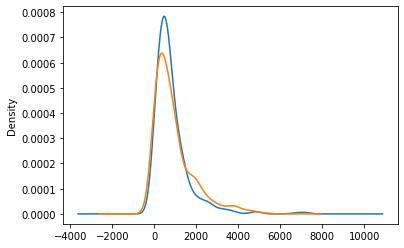

In [7]:
pheno.query('Diagnosis=="Lung Adenocarcinoma"')['Time To Event From Diagnosis (Days)'].plot.kde()
pheno.query('Diagnosis=="Lung Squamous Cell Carcinoma"')['Time To Event From Diagnosis (Days)'].plot.kde()

In [8]:
#pheno[['Overall Survival Status', 'Time To Overall Survival (Days)', 'Tumor Stage']]

# Firstly bi-nominally: what is per tumor stage the probability of death?


In [9]:
stage_map = {'stage i': 'stage 1', 'stage ia': 'stage 1', 'stage ib': 'stage 1',
             'stage ii': 'stage 2', 'stage iia': 'stage 2', 'stage iib': 'stage 2',
             'stage iii': 'stage 3','stage iiia': 'stage 3', 'stage iiib': 'stage 3',
             'stage iv' : 'stage 4'}
pheno['Stage'] = pheno['Tumor Stage'].map(stage_map)

In [10]:
pheno[['Overall Survival Status', 'Stage']].groupby('Stage').aggregate(['mean', 'count'])

Overall Survival Status      
                           mean count
Stage                                
stage 1                0.323160   557
stage 2                0.410959   292
stage 3                0.544379   169
stage 4                0.636364    33

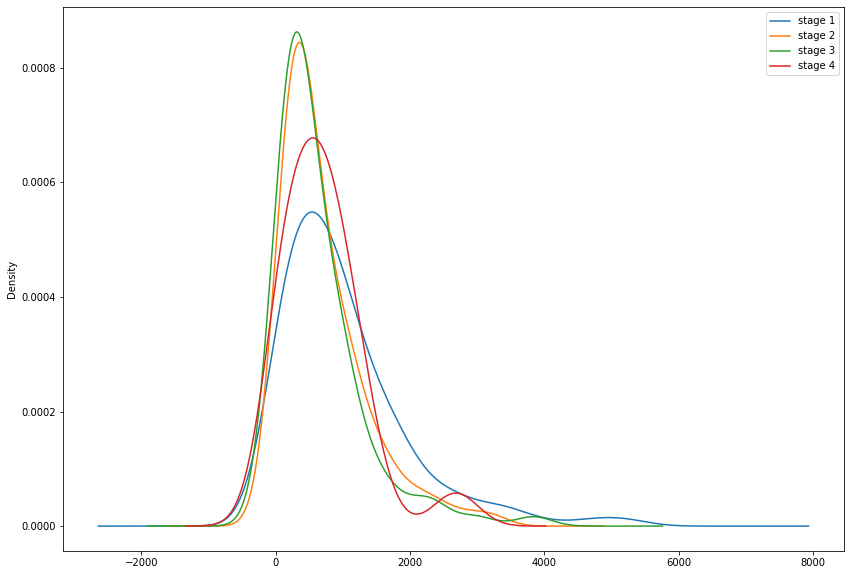

In [7]:
pheno.loc[(pheno['Overall Survival Status']==1) & 
           (pheno['Stage']=='stage 1')]['Time To Overall Survival (Days)'].plot.kde(figsize=(14,10), label='stage 1')
pheno.loc[(pheno['Overall Survival Status']==1) & 
           (pheno['Stage']=='stage 2')]['Time To Overall Survival (Days)'].plot.kde(label='stage 2')
pheno.loc[(pheno['Overall Survival Status']==1) & 
           (pheno['Stage']=='stage 3')]['Time To Overall Survival (Days)'].plot.kde(label='stage 3')
pheno.loc[(pheno['Overall Survival Status']==1) & 
           (pheno['Stage']=='stage 4')]['Time To Overall Survival (Days)'].plot.kde(label='stage 4')
plt.legend()

# Kaplan Meier curves

In [11]:
@jit
def survival(x):
    s = 1
    times = x.sort_values('Time To Overall Survival (Days)')['Time To Overall Survival (Days)'].unique().tolist()
    res = []
    tot_patients = x.shape[0]
    dcountSum = 0
    for _t in times:        
        dcount = x.loc[x['Time To Overall Survival (Days)']==_t]['Overall Survival Status'].sum()
        dcountSum += dcount
        lcount = tot_patients - dcountSum
        s = s*(1-dcount/lcount)
        res.append({'t': _t, 's': s})
    return pd.DataFrame(res)

In [12]:
pheno.Diagnosis.unique()

array(['Lung Adenocarcinoma', nan, 'Lung Squamous Cell Carcinoma'],
      dtype=object)

In [13]:
smoke_map = {'Current Reformed Smoker < or = 15 yrs': 'reformed', 
             'Current Reformed Smoker for > 15 yrs': 'reformed',
             'Current Reformed Smoker, Duration Not Specified': 'reformed',
             'Current Smoker': 'current',
             'Lifelong Non-Smoker': 'non-smoker'}
pheno['Smoking'] = pheno['Smoking Status'].map(smoke_map)

In [14]:
pheno['AgeGroup']= pd.qcut((pheno['Age At Diagnosis (Days)']/365), 5).astype(str)

In [44]:
pheno['PackYearGroup'] = pd.qcut(pheno['Pack Years'], 2).astype(str)

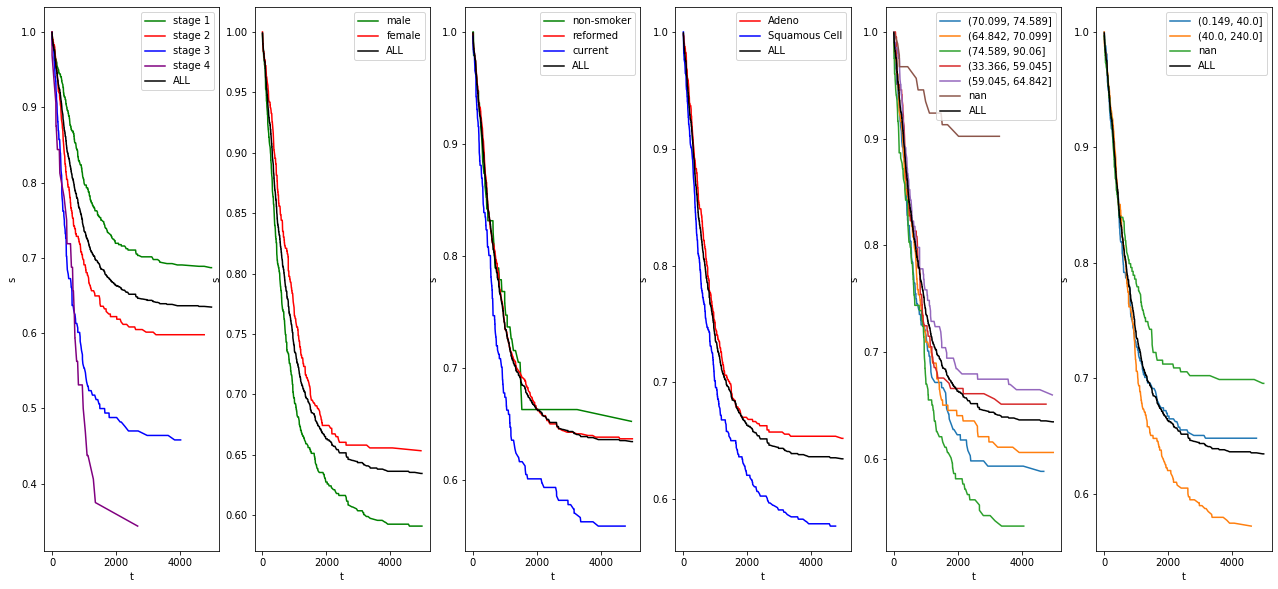

In [45]:
# Gender (male/female), stage 1/2/3/4
#df = survival(pheno[['Time To Overall Survival (Days)', 'Overall Survival Status']])
#sns.lineplot(data=df, x='t' , y='s', color='black')

fig, ax = plt.subplots(figsize=(22,10), ncols=6)

max_days = 5000
base = survival(pheno[['Time To Overall Survival (Days)', 'Overall Survival Status']])

df = survival(pheno.query('Stage=="stage 1"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='green', label='stage 1', ax=ax[0])

df = survival(pheno.query('Stage=="stage 2"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='red', label='stage 2', ax=ax[0])

df = survival(pheno.query('Stage=="stage 3"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='blue', label='stage 3', ax=ax[0])

df = survival(pheno.query('Stage=="stage 4"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='purple', label='stage 4', ax=ax[0])


sns.lineplot(data=base.loc[base.t<max_days], x='t' , y='s', color='black', label='ALL', ax=ax[0])

ax[0].legend()

#######################

df = survival(pheno.query('Gender=="male"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='green', label='male', ax=ax[1])

df = survival(pheno.query('Gender=="female"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='red', label='female', ax=ax[1])

sns.lineplot(data=base.loc[base.t<max_days], x='t' , y='s', color='black', label='ALL', ax=ax[1])

ax[1].legend()

#######################

df = survival(pheno.query('Smoking=="non-smoker"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='green', label='non-smoker', ax=ax[2])

df = survival(pheno.query('Smoking=="reformed"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='red', label='reformed', ax=ax[2])

df = survival(pheno.query('Smoking=="current"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='blue', label='current', ax=ax[2])

sns.lineplot(data=base.loc[base.t<max_days], x='t' , y='s', color='black', label='ALL', ax=ax[2])

ax[2].legend()

#######################

df = survival(pheno.query('Diagnosis=="Lung Adenocarcinoma"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='red', label='Adeno', ax=ax[3])

df = survival(pheno.query('Diagnosis=="Lung Squamous Cell Carcinoma"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='blue', label='Squamous Cell', ax=ax[3])

sns.lineplot(data=base.loc[base.t<max_days], x='t' , y='s', color='black', label='ALL', ax=ax[3])

ax[3].legend()


#######################
for ageQ in pheno.AgeGroup.unique().tolist():
    ageQ = str(ageQ)
    df = survival(pheno.query('AgeGroup=="'+ageQ+'"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
    sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', label=ageQ, ax=ax[4])

sns.lineplot(data=base.loc[base.t<max_days], x='t' , y='s', color='black', label='ALL', ax=ax[4])
ax[4].legend()

#######################
for pack in pheno.PackYearGroup.unique().tolist():
    pack = str(pack)
    df = survival(pheno.query('PackYearGroup=="'+pack+'"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
    sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', label=pack, ax=ax[5])

sns.lineplot(data=base.loc[base.t<max_days], x='t' , y='s', color='black', label='ALL', ax=ax[5])
ax[5].legend()


The phenotypical categorical features that act as confounding variables need to be accounted for when splitting the survival curves by RNA expression values. 
* weighted mean over the pheno survival curves
* base the influence/weight of each phenotype on it's displacement with respect to the overall survival curve

# Bulk survival comparator

In [ ]:
# separation score
# integration of relative differences

# UNIVARIATE
def smooth_survival_curve(x, monotonic=True):
    # apply monotonic cubic spline fit
    x = x.copy().dropna()
    if monotonic:
        return minterp(x.t.values, x.s.values, axis=0, extrapolate=True)
    else:
        return interp(x.t.values, x.s.values, axis=0, extrapolate=True)

In [114]:
def compare_KM(s1, s2):
    scores = {}
    scores['R2'] = r2_score(s1, s2)
    #scores['logrank'] = 
    #scores['hazard_ratio'] = 
    scores['cosine'] = cosine(s1, s2)
    # integral score 1, 2
    # AUC ratio
    # AUC-delta 
    # s-delta AUC
    return scores
    
# select genes to scan
def get_genes(x, min_rel_std=0.5):
    return x.columns[(x.std()/(x.max()-x.min()).mean())>min_rel_std].tolist()
    
# obtain split values 
def get_split_values(x, genelist):
    # use median..
    return x.loc[:,genelist].median().to_dict()


## RNA test

In [12]:
# load in RNA expression data
source_dir = "/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/" #"/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/" "/home/bramvanes/Downloads/data/"
RNA = pd.read_csv(source_dir+"_prepped/RNAexpression_combat_primaryonly_gender_nonparam.csv",
                               sep="\t", engine="python")
RNA_T = RNA.drop(['chr', 'gene', 'start', 'stop', 'strand'], axis=1).set_index('GenX').T

In [108]:
genelist = get_genes(RNA_T, min_rel_std=0.5)
check_genes = get_split_values(RNA_T, genelist)

In [141]:
pheno['sample'] = pheno.index

In [139]:
survival_scores = []
max_days = 3650
start_time = 0
stepsize = 30

# first we extract the splines for the confounded variables 



for _gene in check_genes.keys():
    splitVal = check_genes[_gene]
    
    # separate patient groups
    group1 = RNA_T[RNA_T[_gene]>splitVal].index.tolist()
    group2 = RNA_T[RNA_T[_gene]<=splitVal].index.tolist()

    # get Kaplan-Meier
    df1 = survival(pheno.loc[group1, ['Time To Overall Survival (Days)', 'Overall Survival Status']])
    df2 = survival(pheno.loc[group2, ['Time To Overall Survival (Days)', 'Overall Survival Status']])
                                                                                            
    # get splines
    cs1 = smooth_survival_curve(df1.dropna().query('t<'+str(max_days)).sort_values(by='t'))
    cs2 = smooth_survival_curve(df2.dropna().query('t<'+str(max_days)).sort_values(by='t'))   

    # generate comparable series
    tr = np.arange(start_time, max_days, step_size)
    s1 = cs1(tr,0)
    s2 = cs2(tr,0)

    # now the series can be easily compared using paired methods and unpaired methods.
    # Hazard ratio, log-rank test, custom separation scores (see notes), R2, KS/FDR
    test_scores = compare_KM(s1, s2)

    survival_scores.append({'gene': _gene,
                            'score_R2': test_scores['R2'],
                            'score_cosine': test_scores['cosine']})
    # 'score_logrank': test_scores['logrank'],
    # 'score_hazardratio': test_scores['hazard']
    


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pan

KeyboardInterrupt: 

## survival curves

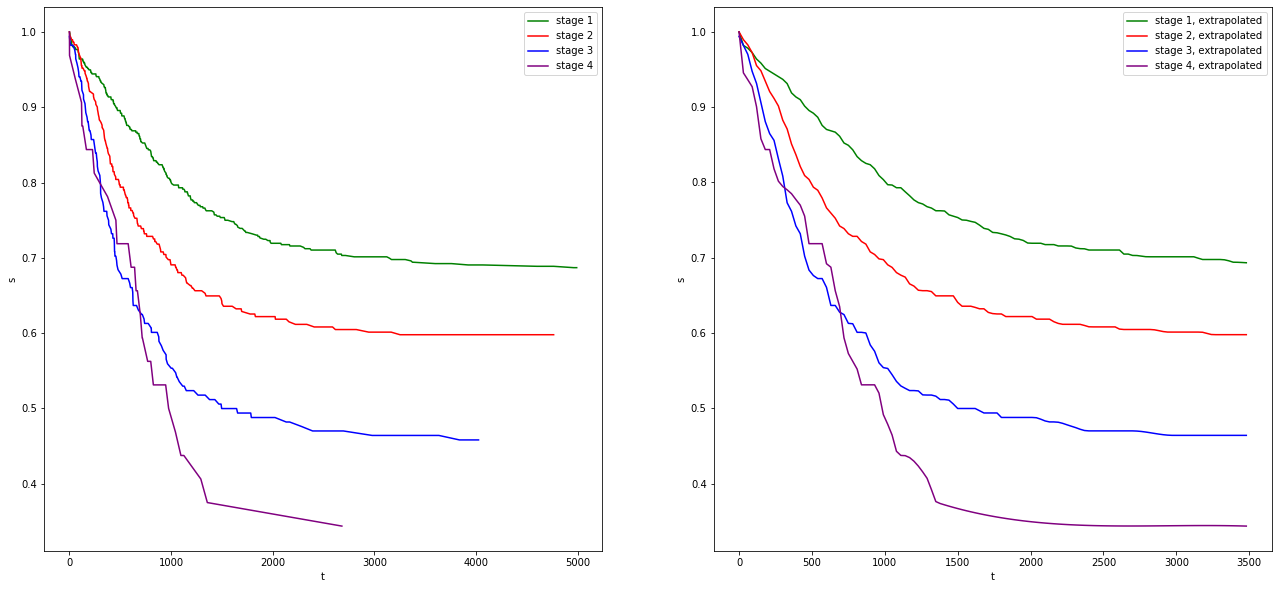

In [112]:
start_time = 0 
end_time = 3500
step_size = 30


fig, ax = plt.subplots(figsize=(22,10), ncols=2)
max_days = 5000
df = survival(pheno.query('Stage=="stage 1"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='green', label='stage 1', ax=ax[0])

df = survival(pheno.query('Stage=="stage 2"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='red', label='stage 2', ax=ax[0])

df = survival(pheno.query('Stage=="stage 3"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='blue', label='stage 3', ax=ax[0])

df = survival(pheno.query('Stage=="stage 4"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='purple', label='stage 4', ax=ax[0])
ax[0].legend()

#######
df = survival(pheno.query('Stage=="stage 1"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
t = np.arange(start_time, end_time, step_size)

df = survival(pheno.query('Stage=="stage 1"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
s = smooth_survival_curve(df)(t)
df = pd.DataFrame(data = np.transpose(np.vstack([t,s])), columns = ['t', 's'])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='green', label='stage 1, extrapolated', ax=ax[1])

df = survival(pheno.query('Stage=="stage 2"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
s = smooth_survival_curve(df)(t)
df = pd.DataFrame(data = np.transpose(np.vstack([t,s])), columns = ['t', 's'])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='red', label='stage 2, extrapolated', ax=ax[1])

df = survival(pheno.query('Stage=="stage 3"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
s = smooth_survival_curve(df)(t)
df = pd.DataFrame(data = np.transpose(np.vstack([t,s])), columns = ['t', 's'])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='blue', label='stage 3, extrapolated', ax=ax[1])

df = survival(pheno.query('Stage=="stage 4"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
s = smooth_survival_curve(df)(t)
df = pd.DataFrame(data = np.transpose(np.vstack([t,s])), columns = ['t', 's'])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='purple', label='stage 4, extrapolated', ax=ax[1])
ax[1].legend()

#######

In [46]:
# COX regression (use https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#the-dataset-for-regression)
# versus pyGAM 
# versus EBM

# MULTIVARIATE


# Immunoresponse clustering

In [253]:
immuno_response = pd.read_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_prepped/immunodata.csv", sep=";", engine="python")
num_cols = immuno_response.columns[immuno_response.dtypes!='object']

In [254]:
from umap import UMAP

In [255]:
immuno_response.set_index('id', inplace=True)

In [256]:
immuno_response.loc[immuno_response['time_years']=='#NULL!', 'time_years'] = 0
immuno_response['time_years_float'] = immuno_response['time_years'].astype(float)
immuno_response['time_years'] = immuno_response['time_years'].astype(float).round().astype(int)
immuno_response['longevity'] = immuno_response['time_years'].apply(lambda x: 'shorter' if x<5 else 'longer')

In [257]:
immuno_response_num = immuno_response.loc[:, num_cols]

In [258]:
reducer = UMAP(min_dist=0.005, n_components=2, target_n_neighbors=5)
immuno_umap = reducer.fit_transform(immuno_response_num)

umap_df = pd.DataFrame(data=immuno_umap, index=immuno_response.index, columns=['umap_1', 'umap_2'])

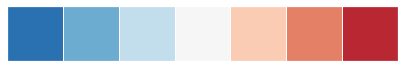

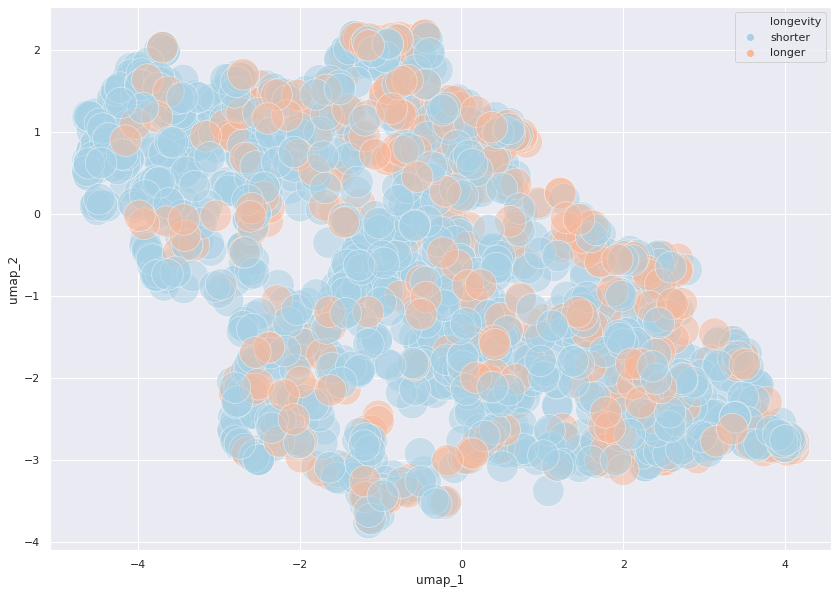

In [259]:
hue_col = 'longevity'
umap_plot = umap_df.join(immuno_response[[hue_col]])

sns.palplot(sns.color_palette("RdBu_r", 7))
sns.set()
sns.set_palette("RdBu_r")

fig, ax = plt.subplots(figsize=(14,10))
sns.scatterplot(data=umap_plot, x='umap_1', y='umap_2', hue=hue_col, alpha=0.5, s=1000, ax=ax, palette="RdBu_r")

In [260]:
from hdbscan import HDBSCAN

In [261]:
clusterer = HDBSCAN(metric='euclidean') # haversine
clusterer.fit(immuno_response_num)
labs = clusterer.labels_
umap_df['hdb_labels'] = labs

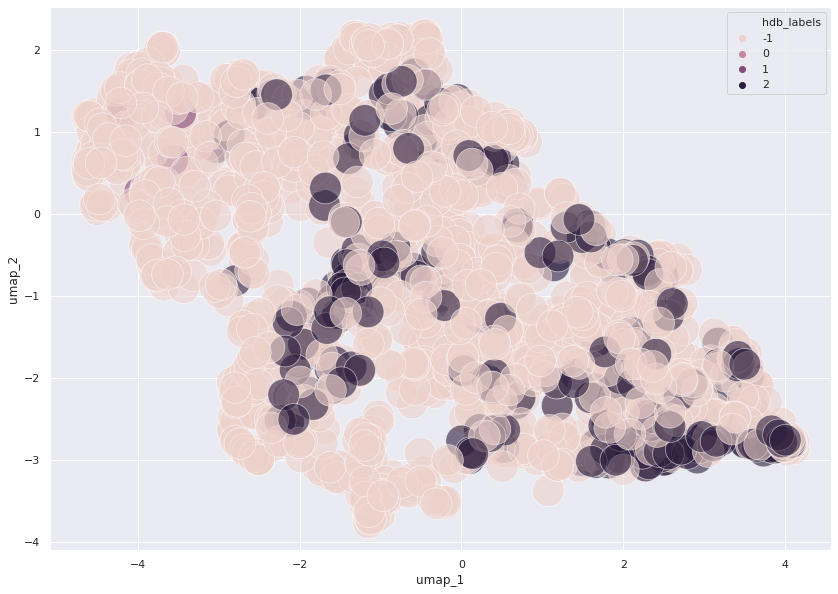

In [262]:
fig, ax = plt.subplots(figsize=(14,10))
sns.scatterplot(data=umap_df, x='umap_1', y='umap_2', hue='hdb_labels', alpha=0.6, s=1000, ax=ax)

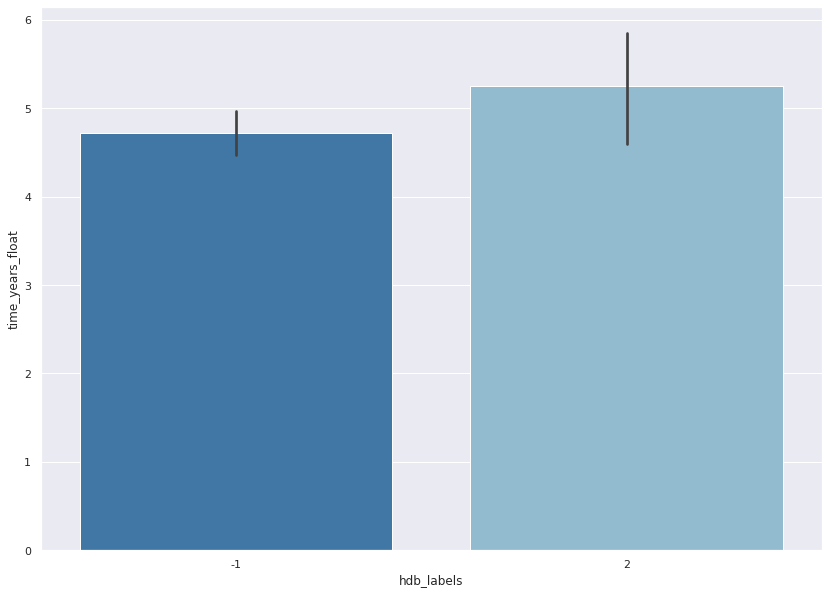

In [263]:
fig, ax = plt.subplots(figsize=(14,10))
tmp = umap_df.join(immuno_response[['time_years_float']])
sns.barplot(data=tmp.query('time_years_float>0'), x='hdb_labels', y='time_years_float', ax=ax)

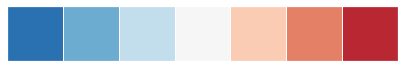

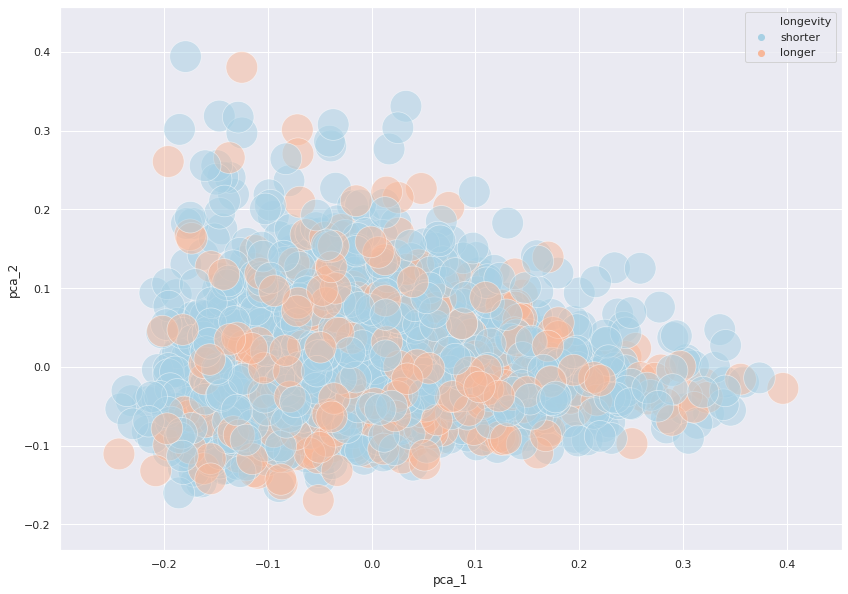

In [264]:
reducer = PCA(n_components=2)
immuno_pca = reducer.fit_transform(immuno_response_num)

pca_df = pd.DataFrame(data=immuno_pca, index=immuno_response.index, columns=['pca_1', 'pca_2'])

hue_col = 'longevity'
pca_plot = pca_df.join(immuno_response[[hue_col]])

sns.palplot(sns.color_palette("RdBu_r", 7))
sns.set()
sns.set_palette("RdBu_r")

fig, ax = plt.subplots(figsize=(14,10))
sns.scatterplot(data=pca_plot, x='pca_1', y='pca_2', hue=hue_col, alpha=0.5, s=1000, ax=ax, palette="RdBu_r")

## Patient to patient clustering

In [266]:
immuno_response_num_T = immuno_response_num.transpose()

In [268]:
patient_corr = immuno_response_num_T.corr()

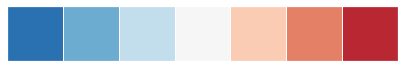

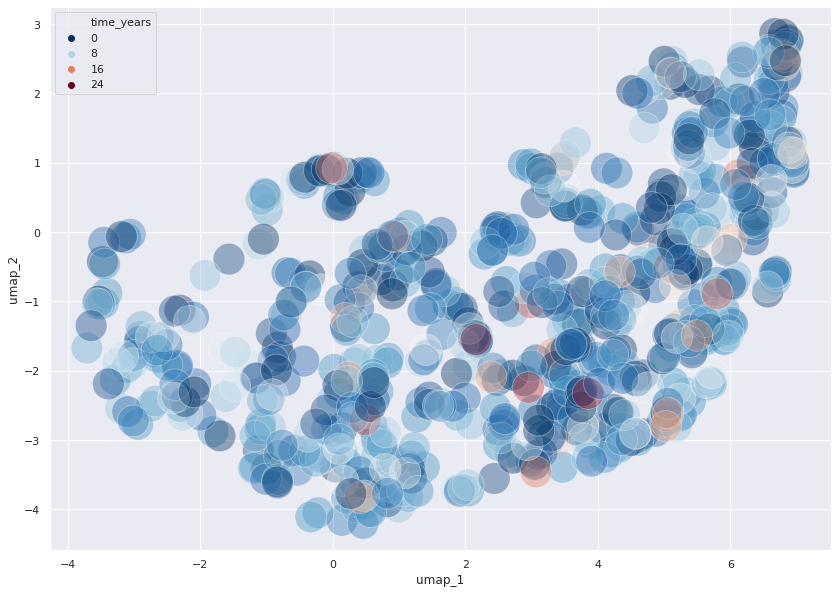

In [282]:
reducer = UMAP(min_dist=0.05, n_components=2, target_n_neighbors=30)
patient_umap = reducer.fit_transform(patient_corr)

umap_df = pd.DataFrame(data=patient_umap, index=patient_corr.index, columns=['umap_1', 'umap_2'])

hue_col = 'time_years'
umap_plot = umap_df.join(immuno_response[[hue_col]])

sns.palplot(sns.color_palette("RdBu_r", 7))
sns.set()
sns.set_palette("RdBu_r")

fig, ax = plt.subplots(figsize=(14,10))
sns.scatterplot(data=umap_plot.query("time_years>0"), x='umap_1', y='umap_2', hue=hue_col, alpha=0.4, s=1000, ax=ax, palette="RdBu_r")

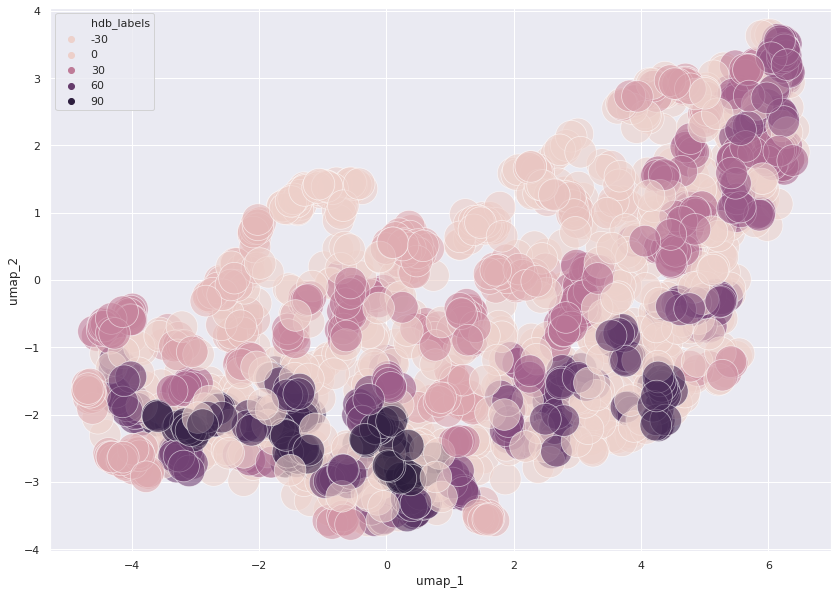

In [278]:
clusterer = HDBSCAN(metric='euclidean') # haversine
clusterer.fit(patient_umap)
labs = clusterer.labels_
umap_df['hdb_labels'] = labs

fig, ax = plt.subplots(figsize=(14,10))
sns.scatterplot(data=umap_df, x='umap_1', y='umap_2', hue='hdb_labels', alpha=0.6, s=1000, ax=ax)

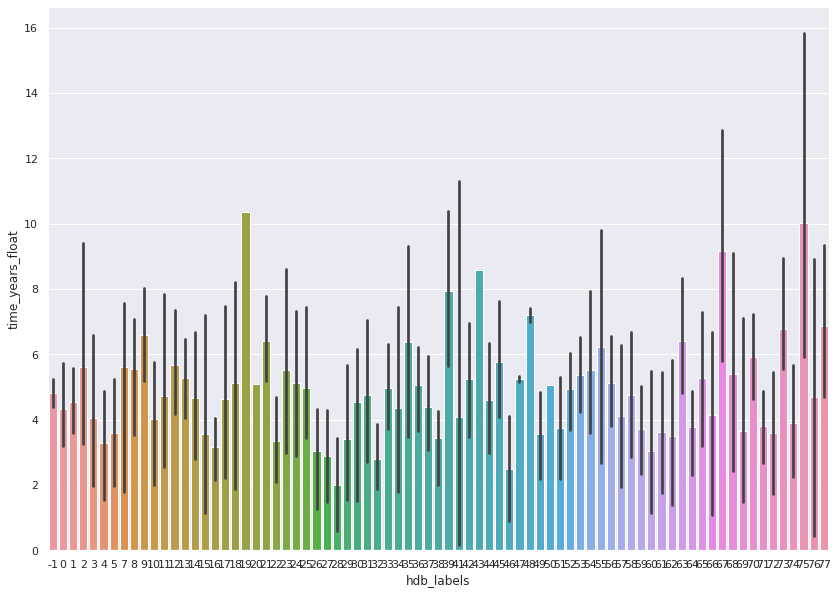

In [276]:
fig, ax = plt.subplots(figsize=(14,10))
tmp = umap_df.join(immuno_response[['time_years_float']])
sns.barplot(data=tmp.query('time_years_float>0'), x='hdb_labels', y='time_years_float', ax=ax)